<a href="https://colab.research.google.com/github/alessiapontiggia/progetto-LABIAGI---Breast-Cancer-Classifier-and-Detection/blob/main/breast_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Detection: Computer Vision

Obiettivo di questa fase è rilevare l'area tumorale sospetta a partire da immagini di mammografie.


# Introduzione alla mammografia: analisi e studio



La mammografia è l'esame con maggiore sensibilità nei tumori in fase iniziale, in particolare nelle mammelle poco dense e quindi radiotrasparenti.
Nella fascia di età 50-69 anni studi di screening hanno dimostrato che la mammografia associata all'esame clinico è in grado di ridurre la mortalità del 30-50%.
La mammografia deve essere eseguita con apparecchiature dedicate e non è comunque esente da possibili errori.

Lo screening mammografico, in Italia, viene eseguito dal 75% delle donne tra i 50 e i 69 anni, fascia di età più a rischio e a cui è consigliabile di sottoporsi al test due volte l'anno per la prevenzione del tumore al seno. 

I dati statistici sono consultabili al seguente link https://www.epicentro.iss.it/passi/dati/ScreeningMammografico .

Le informazioni prettamente mediche citate nel seguente colab sono contenute nella pagina: http://www.raffaeleleuzzi.it/malattia/mammografia.php

L'immagine mammografica tradizionale è un'immagine su pellicola che dopo essere stata realizzata non è più modificabile.
La mammella radiologicamente è costituita da zone a diversa densità, poiché queste aree verranno riprodotte in un'immagine unica, vi saranno zone ben studiabili accanto ad aree non ben rappresentate.



Importiamo le librerie esterne necessarie:

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics

**Funzione di lettura dell'immagine**

In [2]:
def read_img(path):
  img = cv.imread(path, 1)
  print("\nImmagine di esempio di una mammografia: \n")
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])  
  plt.show()
  return img


Immagine di esempio di una mammografia: 



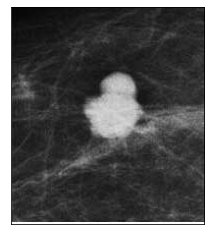

In [3]:
img = read_img("/content/images-11.jpg")

# Segmentazione dell'immagine con maschera




Vediamo i **limiti** principali della mammografia:
 

1.   Mammelle opache
2.   Sede marginale del tumore (solco sottomammario, prolungamento ascellare)
3.   Piccole dimensioni del tumore che lo rendono difficilmente diagnosticabile
4.   Scarsa densità del carcinoma o il suo presentarsi a margini regolari
5.   Il nodulo tumorale è dotato di una differenza di contrasto troppo bassa nei confronti del tessuto circostante


Proviamo a risolvere il problema della differenza di contrasto con delle tecniche di computer vision.

Per evidenziare al meglio il contrasto, si usa nel seguito una **maschera**.

Di seguito riporto i boundaries del colore (bianco) su cui viene applicata:

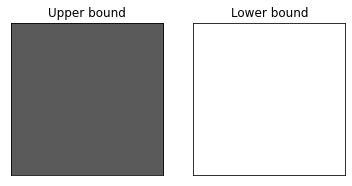

In [4]:
dark_white = (0, 0, 90)
light_white = (0, 0, 255)

lw_square = np.full((10, 10, 3), dark_white, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), light_white, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.xticks([]), plt.yticks([])
plt.title("Upper bound")
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.title("Lower bound")
plt.imshow(hsv_to_rgb(dw_square))
plt.xticks([]), plt.yticks([])
plt.show()

**Funzione che produce la maschera e suo risultato su un immagine**

Per poter lavorare con i colori delle immagini ed estrarre informazioni a partire da essi:

*   Convertiamo dapprima l'immagine nello spazio HSV (Hue-Saturation-Value) con la funzione *cvtColor.* 
OpenCV, infatti, di default *legge* le immagini nello spazio RGB.
*   Calcoliamo la maschera, binaria, sull'immagine a partire dai bounderies definiti precedentemente, con la funzione *inRange*.
*   Il metodo *bitwise_and* produce il risultato della maschera applicata all'immagine di partenza. Ciò che fa è evidenziare in bianco l'area dell'immagine che "rientra" nel range della maschera, il resto viene reso nero. 


Il risultato delle operazioni sopra descritte è riportato con le immagini della maschera (a sinistra) e del risultato di questa applicata alla sorgente (a destra), sotto la sezione di codice: 

In [5]:
def get_mask(img):
  hsv_img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
  mask = cv.inRange(hsv_img, dark_white, light_white) 
  result = cv.bitwise_and(img, img, mask=mask)
  plt.subplot(1, 2, 1)
  plt.xticks([]), plt.yticks([])
  plt.title("Maschera")
  plt.imshow(mask, cmap="gray")
  plt.subplot(1, 2, 2)
  plt.xticks([]), plt.yticks([])
  plt.title("Risultato")
  plt.imshow(result)
  plt.show()
  return mask, result

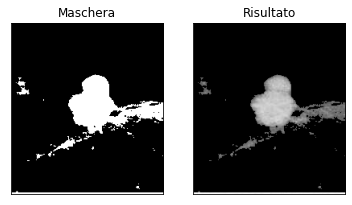

In [6]:
mask, result = get_mask(img)

**Funzione che delinea i contorni di una zona di interesse**

Il segno più comune di patologia mammaria è l'opacità nodulare che può essere rotondeggiante, ovalare, lobulata ed irregolare.
Le opacità a margini netti sono di regola di natura benigna (cisti, fibroadenomi) mentre quelle a margini irregolari sono di natura maligna ad esclusione degli esiti chirurgici cicatriziali e delle adenosi sclerosanti.
I segni più rappresentativi di tumore sono le formazioni opache a contorni irregolari o francamente sfrangiati, la distorsione della struttura ghiandolare, le microcalcificazioni polimorfe vermiculari con andamento irregolare o ramificato

Risulta utile quindi evidenziare i contorni dell'area in risalto per una migliore e più attenta analisi: 

In [ ]:
def make_contours(mask, result):  
  contours, hierarchy = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  output = cv.drawContours(result.copy(), contours, -1, (255, 0, 0), 1)
  plt.imshow(output)
  return output

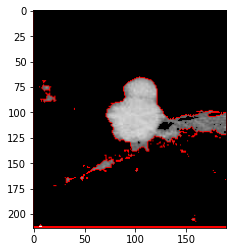

In [ ]:
output = make_contours(mask, result)

# Detection dell'area tumorale sospetta: K-Means

Con **area tumorale sospetta** si definisce, *per puro scopo implementativo*, la zona "bianca" che occupa più del 25% dell'area bianca totale rilevata dal processo di segmentazione.


**Funzione che definisce le coordinate dei pixel bianchi**

Ora individuiamo le coordinate dei pixel evidenziati appartenenti alla zona bianca. Per semplicità useremo come immagine di riferimento la maschera, poiché ha un solo canale e due soli valori possibili per ogni pixel, 0 (nero) o 255 (bianco).

Ricordiamo che la maschera e l'immagine originaria hanno la stessa dimensione, quindi i pixel trovati avranno la stessa posizione in entrambe.


*Si precisa inoltre che la detection si effettua a partire dalle dimensioni che una certa zona ha, non dalla sua forma poiché quest'ultima non è uniforme.*


In [ ]:
def light_white_pixel(img):
  l = []
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j]==255:
        l.append((i,j))
  return l

In [ ]:
white_coord_pixels = light_white_pixel(mask)
n_white_pixels = len(white_coord_pixels)
n_total_pixels = mask.shape[0]*mask.shape[1]

print("Numero di pixels bianchi trovati "+str(len(white_coord_pixels))+" su "+str(mask.shape[0]*mask.shape[1]))
print("La densità è:", np.round((len(white_coord_pixels)/(mask.shape[0]*mask.shape[1]))*100,2))

Numero di pixels bianchi trovati 5009 su 40660
Come visto sopra, la densità è: 12.32


Vediamo come queste coordinate sono distribuite nell'immagine in un grafico:

In [ ]:
def show_distribution(list_of_coords):
  for coord in list_of_coords:
    x = coord[0]
    y = coord[1]
    plt.plot(x,y, color="black", marker=".")
  plt.title("Distribuzione dell'area bianca")
  plt.show()
  return 

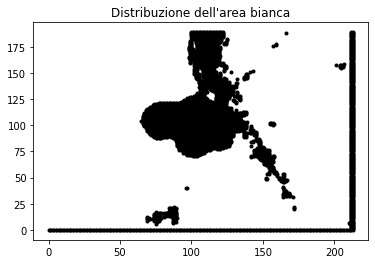

In [ ]:
show_distribution(white_coord_pixels)

Usiamo **K-Means** per suddividere i punti (coordinate) in K cluster. *Useremo come primo tentativo K=5*.

In [ ]:
K = 5

In [ ]:
def K_Means(list_of_pixels):
  # K-Means
  kmeans = KMeans(n_clusters=5, random_state=0) 
  df = pd.DataFrame(list(list_of_pixels))

  # fitting the values
  kmeans.fit(df)

  # centroidi
  centroids = kmeans.cluster_centers_

  # appartenenza delle coordinate del dataset a un certo cluster
  l = kmeans.labels_

  return df, centroids, l

In [ ]:
df, c, l = K_Means(white_coord_pixels)

**Funzione che disegna i centroidi scelti**

In [ ]:
def draw_centroids(centroids):
  colors = ["red", "green", "blue", "orange", "violet"]
  i=0
  if len(colors)==len(centroids):
    for centroid in centroids:
      x_c = centroid[0]
      y_c = centroid[1]
      plt.xlim(0,200)
      plt.ylim(0,200)
      plt.plot(x_c,y_c, color=colors[i], marker="x", label="centroid "+str(i+1))
      i = i+1
    plt.legend(loc="lower left")
    plt.title("Centroids")
    plt.show()
  return 

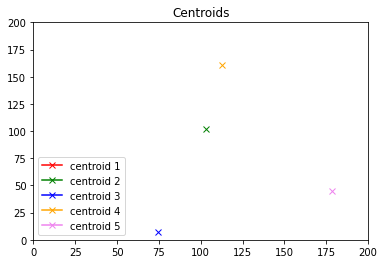

In [ ]:
draw_centroids(c)

**Funzione che disegna i clusters** 

In [ ]:
def draw_clusters(c, l, white_coord_pixels):
  first_centroid_color = "red"
  second_centroid_color = "green"
  third_centroid_color = "blue"
  fourth_centroid_color = "orange"
  fifth_centroid_color = "violet"
  for i in range(len(l)):
    x = white_coord_pixels[i][0]
    y = white_coord_pixels[i][1]
    if l[i] == 0:
      plt.plot(x,y, color=first_centroid_color, marker=".")
    elif l[i] == 1:
      plt.plot(x, y, color=second_centroid_color, marker=".")
    elif l[i] == 2:
      plt.plot(x, y, color=third_centroid_color, marker=".")
    elif l[i] == 3:
      plt.plot(x, y, color=fourth_centroid_color, marker=".")
    else:
      plt.plot(x, y, color=fifth_centroid_color, marker=".")
  plt.title("Appartenenza dei pixel al cluster del rispettivo centroide")
  plt.show()
  return

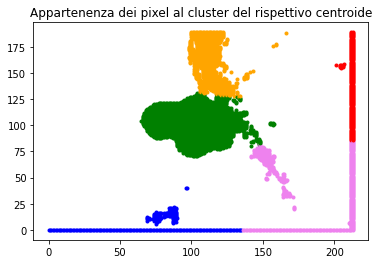

In [ ]:
draw_clusters(c, l, white_coord_pixels)

**K: valore ottimo**

Come capire qual è il k migliore? Utilizziamo l'indice di Silhouette:

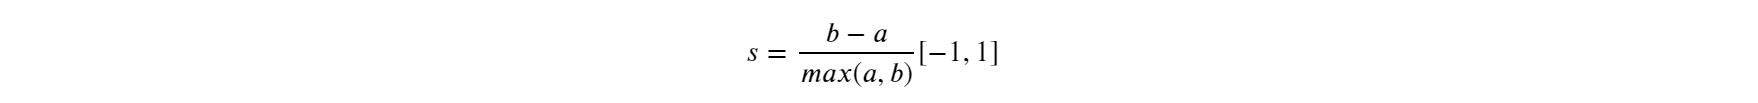

Dove:

a = *distanza media intracluster*
b = *distanza media extracluster*

In [ ]:
k_to_test = range(2,10,1) # [2,3,4, ..., 24]
silhouette_scores = {}

for k in k_to_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(df)
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(df, labels_k)
    silhouette_scores[k] = score_k
    print("Tested kMeans with k = %d\tS: %5.4f" % (k, score_k))

Tested kMeans with k = 2	S: 0.5210
Tested kMeans with k = 3	S: 0.4460
Tested kMeans with k = 4	S: 0.5082
Tested kMeans with k = 5	S: 0.5270
Tested kMeans with k = 6	S: 0.4478
Tested kMeans with k = 7	S: 0.4441
Tested kMeans with k = 8	S: 0.4575
Tested kMeans with k = 9	S: 0.4614


Tra tutti dobbiamo prendere il K con valore di S più alto:

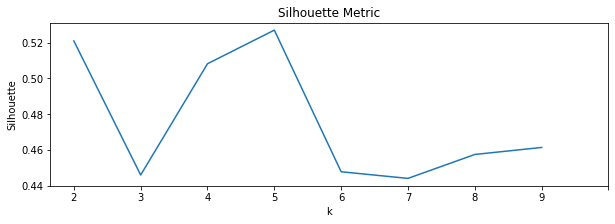

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(list(silhouette_scores.values()))
plt.xticks(range(0,9,1), silhouette_scores.keys())
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

Come abbiamo visto il k migliore è proprio 5, poiché a questo valore corrisponde il massimo indice di silhouette.

**Funzione che evidenzia l'area tumorale sospetta**

Ora evidenziamo nell'immagine originaria l'area dei cluster più ampi, poiché è in quella zona che è più probabile ci sia la massa tumorale.

In [ ]:
def draw_suspicious_area(white_coord_pixels, l, result):
  labels = [i for i in range(0,K)]    # numero dei centroidi
  ll = list(l)
  occ = [ll.count(i) for i in range(0,K)]
  idx_max_area = occ.index(max(occ))

  print("Il cluster più popolato è il numero:", labels[idx_max_area]+1)

  idx = [idx_max_area]
  for o in occ:
    if (o/len(white_coord_pixels))>=0.25:  
      if occ.index(o) not in idx:
        idx.append(occ.index(o))

  chosen_clusters = [labels[i] for i in idx]
  for i in range(len(l)):
    x = white_coord_pixels[i][0]
    y = white_coord_pixels[i][1]
    if l[i] in chosen_clusters:
      result[x][y] = (255,0,0)

  plt.title("Area tumorale sospetta")
  plt.imshow(result)
  return 

Il cluster più popolato è il numero: 2


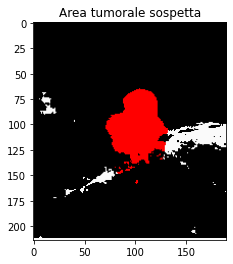

In [ ]:
draw_suspicious_area(white_coord_pixels, l, result)

# Test con altre immagini

Testiamo la procedura su altre immagine:




> Esempio 1




Immagine di esempio di una mammografia: 



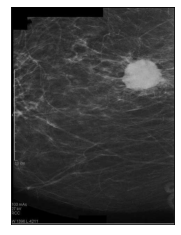

In [ ]:
img2 = read_img("/content/m000.jpg")

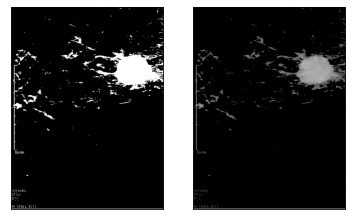

In [ ]:
mask2, result2 = get_mask(img2)

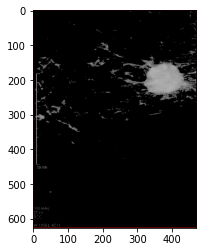

In [ ]:
output2 = make_contours(mask2, result2)

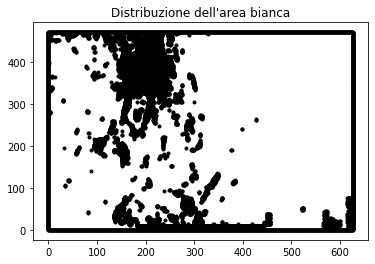

In [ ]:
white_coord_pixels2 = light_white_pixel(mask2)
show_distribution(white_coord_pixels2)

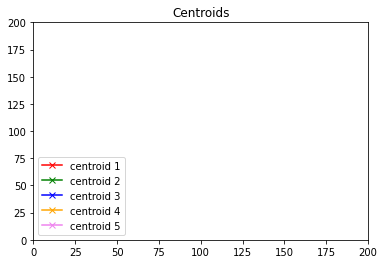

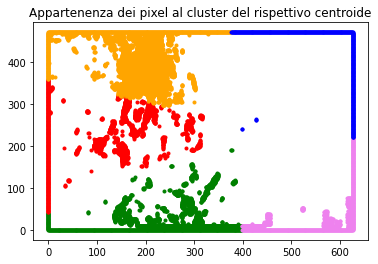

In [ ]:
df2, c2, l2 = K_Means(K, white_coord_pixels2)
draw_centroids(c2)
draw_clusters(c2, l2, white_coord_pixels2)

Il cluster più popolato è il numero: 4


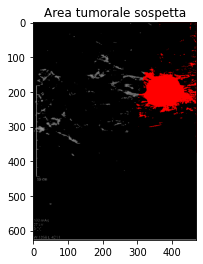

In [ ]:
draw_suspicious_area(white_coord_pixels2, l2, result2)



> Esempio 2




Immagine di esempio di una mammografia: 



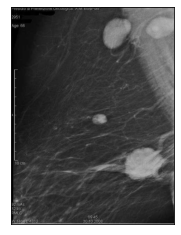

In [ ]:
img3 = read_img("/content/multiple_areas.jpg")

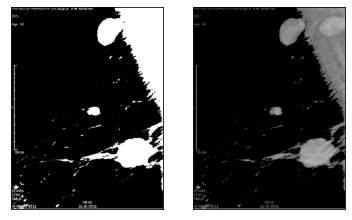

In [ ]:
mask3, result3 = get_mask(img3)

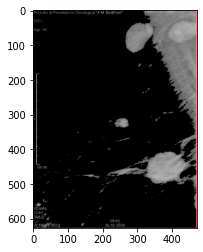

In [ ]:
output3 = make_contours(mask3, result3)

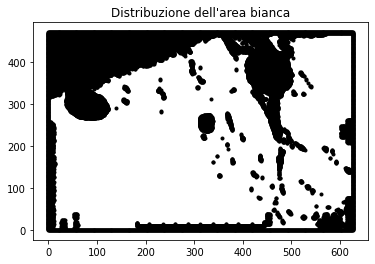

In [ ]:
white_coord_pixels3 = light_white_pixel(mask3)
show_distribution(white_coord_pixels3)

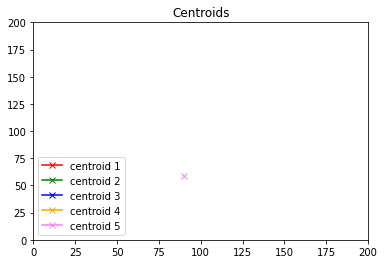

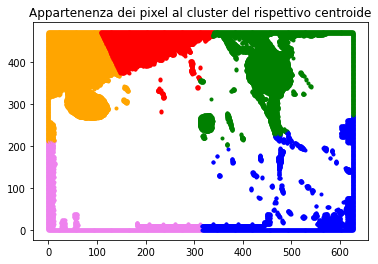

In [ ]:
df3, c3, l3 = K_Means(K, white_coord_pixels3)
draw_centroids(c3)
draw_clusters(c3, l3, white_coord_pixels3)

Il cluster più popolato è il numero: 4


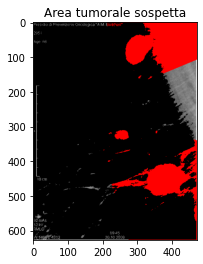

In [ ]:
draw_suspicious_area(white_coord_pixels3, l3, result3)